### Indexfonds vs. ETF

In [11]:
from pandas import read_csv, concat, DataFrame, Series, ExcelWriter
from pprint import pprint

%matplotlib inline

##### Define a function to fit ETF prices to index

In [12]:
def calc_faktor(df, iday_fonds, iday_idx):
    '''
    calculate faktor to minimize square deviation )
    '''
    if iday_fonds == iday_index: return 1
    print(iday_fonds, ' ', iday_idx)
    cnt = 0
    inc  = 20
    faktor = 1
    diffold = 1e9
    while (cnt < 100) and (abs(inc) > 0.001):
        cnt += 1
        diff = ((faktor * df[iday_fonds]-df[iday_idx])**2).sum()
        if diff > diffold:
            inc = -inc/2
            #print('True',end=' ')
        faktor = faktor + inc
        #print('{0:4.0f} faktor:{1:12.8f} inc:{2:10.6f}   diff:{3:.0f} diffold {4:.0f} {5:.0f}'
        #     .format(cnt, faktor, inc, diff, diffold, diff-diffold))
        diffold = diff
    return faktor

In [13]:
# create list of .csv filenames
fname = 'info_market_data_download_id(x).csv'
fnamelist = [fname.replace('x',str(i)) for i in range(1,4)]
pprint(fnamelist)
# read intraday prices from csv files and write into dataframe
prcs_list = {}
iday_index = '' 
names = []
for i, fn in enumerate(fnamelist):
    temp = read_csv(fn, skiprows=2, sep=';',index_col=0)
    temp = temp.Price
    name1, name2 = read_csv(fn, nrows=1, encoding='latin-1').to_string().split('\n')
    name1 = name1.strip(' ').replace(' ', '-').replace('\xa0','')
    name2 = name2[-11:-1]
    name = name1+'-'+name2
    names.append(name)
    temp.name=name
    temp.index.name = None
    prcs_list[i] = temp
    if 'CH0009987501' in name: iday_index = name # remember SPI index
id_prcs = concat(prcs_list,axis=1)
id_prcs.columns = names
id_prcs.index = ('2016-09-30'+id_prcs.index).to_datetime()
# create dataframe with full matrix
id_prcsclean = id_prcs.interpolate().ffill().bfill()
pprint(names)

['info_market_data_download_id(1).csv',
 'info_market_data_download_id(2).csv',
 'info_market_data_download_id(3).csv']
['SPI®-TR(SXGE/CH0009987501)-30.09.2016',
 'UBS-ETF-SPI-(CHF)-A(SPICHA/CH0131872431)-30.09.2016',
 'iShares-Core-SPI-(CH)(CHSPI/CH0237935652)-30.09.2016']


##### adjust all time series to same scale

In [14]:
id_prcsadj = id_prcs
id_prcsadj[iday_index] = id_prcsadj[iday_index].interpolate().ffill().bfill()
for name in names:
    ff = calc_faktor(id_prcsclean, name, iday_index)
    id_prcsclean[name] *= ff
    id_prcsadj[name] *= ff    

UBS-ETF-SPI-(CHF)-A(SPICHA/CH0131872431)-30.09.2016   SPI®-TR(SXGE/CH0009987501)-30.09.2016
iShares-Core-SPI-(CH)(CHSPI/CH0237935652)-30.09.2016   SPI®-TR(SXGE/CH0009987501)-30.09.2016


#### show a chart

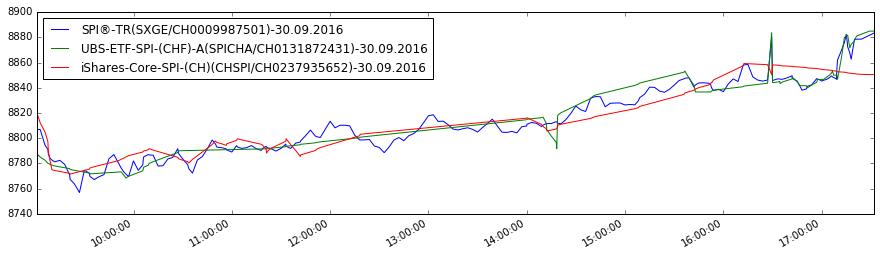

In [6]:
_ = id_prcsclean.plot(figsize=(15,4))

##### create an excel file for charts

In [9]:
writer = ExcelWriter('auswertungraw.xlsx')
id_prcs.to_excel(writer,'id_prcs')
id_prcsclean.to_excel(writer,'id_prcsclean')
id_prcsadj.to_excel(writer,'id_prcsadj')
writer.save()